<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/thesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget file.weasoft.com/images.zip
!wget file.weasoft.com/summary.csv
!git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
!pip install focal_loss_torch wandb
!pip3 install deepsmiles yacs tqdm
!wget file.weasoft.com/model.py -O model.py
!wget file.weasoft.com/reverse.map

In [ ]:
!python3 --version


Python 3.10.12


In [ ]:
!unzip images.zip

Archive:  images.zip
  inflating: 10952_050583472155929066.png  
  inflating: 10952_06413864577904915.png  
  inflating: 10952_0987733374849662.png  
  inflating: 10952_10418284106334552.png  
  inflating: 10952_16580034422892975.png  
  inflating: 10952_23370361265754647.png  
  inflating: 10952_2592774190030849.png  
  inflating: 10952_46352491565819787.png  
  inflating: 10952_5437104182840758.png  
  inflating: 10952_7528510827860566.png  
  inflating: 10952_8472447206478343.png  
  inflating: 10952_9943772215519315.png  
  inflating: 11182_009797678782551.png  
  inflating: 11182_056521676103760465.png  
  inflating: 11182_06305573566312661.png  
  inflating: 11182_06673381672094503.png  
  inflating: 11182_09202768527861127.png  
  inflating: 11182_09932843308058081.png  
  inflating: 11182_10408978036627115.png  
  inflating: 11182_10983032013014726.png  
  inflating: 11182_1262978826120098.png  
  inflating: 11182_1314325210419437.png  
  inflating: 11182_17841757812291215.png 

In [ ]:
!mkdir -p images
!mv *.png images
!mv *.webp images

In [ ]:
from model import *

In [ ]:
!ls drive/MyDrive/*.pt

drive/MyDrive/20240207_final.pt  drive/MyDrive/all.data.pt	     drive/MyDrive/large_set.7.pt
drive/MyDrive/97.7.pt		 drive/MyDrive/final.98.pt	     drive/MyDrive/sweep.pt
drive/MyDrive/97.pt		 drive/MyDrive/final.with.test.7.pt
drive/MyDrive/9lrge7.7.pt	 drive/MyDrive/good_one.pt


In [ ]:
import torch, torchvision
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
# mod = torch.load("drive/MyDrive/all.data.pt", map_location=device)
mod = torch.load("drive/MyDrive/sweep.pt", map_location=device) #duzikunkkiknow why i need to /255
#

In [ ]:
t = 1
import deepsmiles
from PIL import Image
import json


converter = deepsmiles.Converter(rings=True, branches=True)
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask

def top_k_2d(m, k):
  values, indices = torch.topk(m.flatten(), k)
  return indices//m.shape[1], indices%m.shape[1]

def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

reversed_word_map = {}

with open("reverse.map","r") as f:
  reversed_word_map = json.loads(f.read())
reversed_word_map_={}

for i in reversed_word_map.keys():
  reversed_word_map_[int(i)] = reversed_word_map[i]


In [ ]:
import numpy as np
def generate(img):
  global mod
  mod = mod.train(False)
  with torch.no_grad():
    mem = mod.decoder.encoder(mod.decoder.encoder_dim(mod.encoder(img)))
    seq = torch.tensor([[77]]).to(device)
    for i in range(100):
      out = mod.decoder.decoder(seq, mem, x_mask=triangle_mask(len(seq)).to(device))[:,-1,:].squeeze(dim=1)
      id = torch.argmax(out, dim=-1)
      if id.item()==78:
        return seq
      seq = torch.concat((seq, id.unsqueeze(0)),dim=-1)

# img1 = torch.tensor(np.array(Image.open("images/"+name).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# ans = generate(img1)
# converter.decode("".join([reversed_word_map_[i] for i in ans[0].numpy()])).replace("<start>","")

In [ ]:
torch.save(mod.state_dict(), "drive/MyDrive/final.dict")


In [ ]:
reversed_word_map

In [136]:
import numpy as np
import os
import random
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.out = []

  def predict_next(self, i, out, beam, alpha):
    factor = torch.ones(self.top_n_p.shape)
    if i>=1:#forget >=, write factor found this, what causing the reuslt?
      for j in range(beam):
        if self.top_n[j][-1]==78:
          out[j]=torch.zeros(79)
          out[j][78]=1 #0 not 1

        L = len(self.top_n[0])
        try:
          L = (self.top_n[j]==78).nonzero()[0]+1
          # if L.item()==2:
          #   L[0]=torch.inf #yao [0[]]
        except:
          pass
        factor[j] = L

        # print(L)
      # print(factor)
    # print((self.top_n_p.repeat((79,1)).T+torch.log(out)).shape)
    tmp_n = (self.top_n_p.repeat((79,1)).T+torch.log(out))*(1/(factor**alpha)).repeat(79,1).t()
    # print((1/(factor**alpha)).t().shape)
    # print((self.top_n_p.repeat((79,1)).T+torch.log(out)).shape)
    x, y = top_k_2d(tmp_n, beam)
    # print(x,y)
    new_top_n = []
    new_top_n_p = []
    if i==0:
      factor = torch.zeros(beam)*(1/(1**alpha))
    for j in range(beam):
      new_top_n.append(torch.cat((self.top_n[x[j]], y[j].cpu().unsqueeze(-1))))
      new_top_n_p += [tmp_n[x[j], y[j]]/((1/(factor[j]**alpha)))]#return to befpre L
    self.top_n = new_top_n
    self.top_n_p = torch.tensor(new_top_n_p).to(device)


  def forward(self, images, text_in_=[[77]], max_len=100, beam=1,alpha=0.75, method = "sum"): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    with torch.no_grad():
      image_feature = []
      for i in images:
        mem = self.decoder.encoder(self.decoder.encoder_dim(self.encoder(i)))
        mem = mem.repeat_interleave(beam, dim=0)
        image_feature.append(mem)


      self.top_n = torch.tensor(text_in_)
      self.top_n_p = torch.tensor([0.]).to(device)
      for i in range(max_len):
        padded_text , l = pad_pack(self.top_n)
        padded_text = padded_text.to(device)
        out = []
        for j in range(len(images)):
          out.append(self.decoder.decoder(padded_text, image_feature[j], x_mask=triangle_mask(l).to(device))[:,-1,:].squeeze(dim=1))
        self.out.append(torch.stack(out))
        if method == "sum":
          for j in range(len(out)):
            out[j] = torch.nn.functional.softmax(out[j], dim=1)
          out = torch.sum(torch.stack(out), dim=0)
        else:
          print("BOOOM")
          raise TypeError()
        self.predict_next(i, out, beam, alpha)
        count = 0
        for i in self.top_n:
          if 78 in i:
            count+=1
        if count==beam:
          return self.top_n, self.top_n_p
      return self.top_n, self.top_n_p

val_cids = [286, 6587, 6562, 11203]
val_names = [i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cids]


mod = mod.eval()
gen = SMILESGenerator(mod.encoder, mod.decoder)
name = random.choice(val_names)
print(name)
img1 = torch.tensor(np.array(Image.open("images/"+name).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
gen = gen.train(False) #forgot gen=
res = gen.forward([img1], beam=10)
print()
for i in res[0]:
  print(converter.decode("".join([reversed_word_map_[i] for i in i.numpy()])))
print(torch.exp(res[1]))


6562_2138605173649507.png

<start><end><end><end><end><end><end><end><end><end><end>
<start>CC(=C)C=O<end><end>
<start>BC(=C)C=O<end><end>
<start>NC(=C)C=O<end><end>
<start>OC(=C)C=O<end><end>
<start(>)C(=C)C=O<end><end>
<star1t>1C(=C)C=O<end><end>
<st1art>1C(=C)C=O<end><end>
<start>=C(C)C=O<end><end><end>
<start>=CC(=C)C=O<end>
tensor([1.0000, 0.9120, 0.8848, 0.8594, 0.8590, 0.7687, 0.5898, 0.5895, 0.4736,
        0.3534])


tensor([], size=(0, 1), dtype=torch.int64)

In [ ]:
!pip install onnx
!pip install onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.4/518.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
torch.onnx.dynamo_export(gen, img1)

/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues

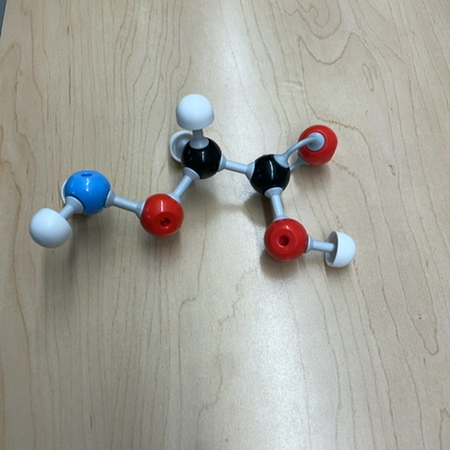

In [ ]:
Image.open("images/286_45263980661967973.png")

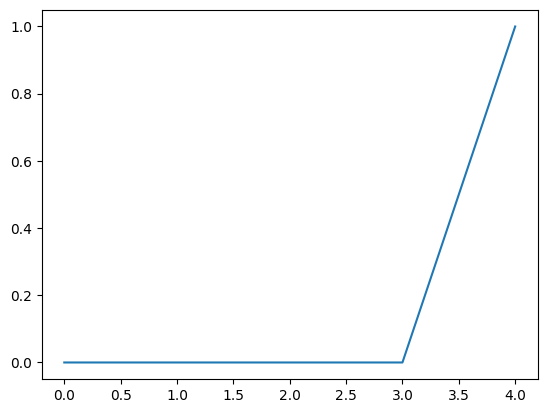

In [ ]:
import pylab
def softmax(x):
  t = np.exp(np.array(x)*10)
  return t/np.sum(t)
pylab.plot(softmax([1,0,2,3,5]))

In [ ]:
val_names

['286_26186591590584574.png',
 '286_6910048371489252.png',
 '286_291519054706887.png',
 '286_3849802650697731.png',
 '286_8176025030280614.png',
 '286_9876611480246069.png',
 '286_7037578211027036.png',
 '286_6479478203003403.png',
 '286_14123141185338928.png',
 '286_8002224118613194.png',
 '286_1178357204822813.png',
 '286_8879386141596759.png',
 '286_6442431984647838.png',
 '286_3448409759190625.png',
 '286_9340428295738961.png',
 '286_841600412992074.png',
 '286_41006764947428587.png',
 '286_5760972837401569.png',
 '286_13144353196490932.png',
 '286_45263980661967973.png',
 '286_5832224334909873.png',
 '286_6835455078191323.png',
 '286_62776193878468.png',
 '286_8009949225635042.png',
 '286_059227563232289726.png',
 '286_8650773050302389.png',
 '286_9823380938991615.png']

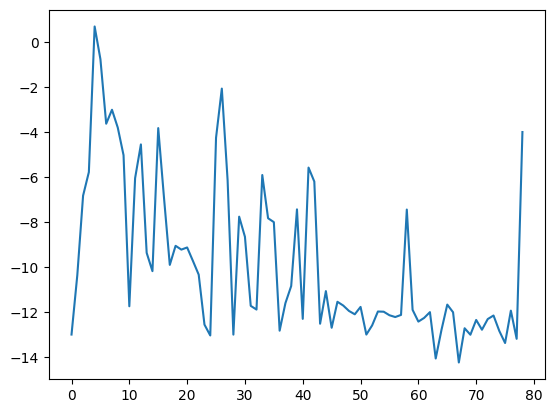

In [ ]:
pylab.plot(torch.stack(gen.out[1:])[0,0,0].cpu().detach().t())

In [ ]:
def myeval(img_paths, beam, method, r):
  global gen
  if type(img_paths)!=list:
    img_paths = [img_paths]
  imgs = []
  for img_path in img_paths:
    imgs.append(torch.tensor(np.array(Image.open(img_path).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32))
  gen = SMILESGenerator(mod.encoder, mod.decoder)
  gen = gen.train(False)
  res = gen.forward(imgs, [[77]], 100, beam, r=r)
  ans = ""
  for i in range(beam):
    ans+=converter.decode("".join([reversed_word_map_[i.item()] for i in res[0][i]]))+"\n"
  return ans.replace("<start>","").replace("<end>","")

In [ ]:
# t = 1

# class SMILESGenerator(torch.nn.Module):
#   def __init__(self, encoder, decoder):
#     super().__init__()
#     self.encoder = encoder
#     self.decoder = decoder

#   def forward(self, images, text_in_, max_len, beam, r=0.05): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
#     with torch.no_grad():
#       image_feature = []
#       for i in images:
#         image_feature.append(self.encoder(i))
#       image_feature = torch.stack(image_feature)
#       # print(image_feature.shape)
#       image_feature = image_feature.squeeze(1)
#       mem = gen.decoder.encoder(gen.decoder.encoder_dim(image_feature))
#       mem = torch.mean(mem, dim=0)
#       mem = mem.unsqueeze(0).repeat_interleave(beam, dim=0)
#       # return mem
#       top_n = torch.tensor(text_in_)
#       top_n_p = torch.tensor([0.]).to(device)
#       for i in range(max_len):
#         padded_text, l = pad_pack(top_n)
#         padded_text = padded_text.to(device)
#         # print(padded_text)
#         out = torch.nn.functional.softmax(self.decoder.decoder(padded_text, mem, x_mask=triangle_mask(l).to(device))[:,-1,:].squeeze(dim=1), dim=1)
#         # pylab.plot(out[0])
#         # pylab.show()
#         reward = torch.zeros(top_n_p.shape)
#         if i>1:
#           for j in range(beam):
#             if top_n[j][-1]==78:
#               out[j]=torch.zeros(79)
#               out[j][78]=1
#               reward[j]=(0.)
#             else:
#               reward[j]=(r)
#         top_n_p+=reward.to(device)
#         tmp_n = top_n_p.repeat((79,1)).T+torch.log(out)
#         x, y = top_k_2d(tmp_n, beam)
#         new_top_n = []
#         new_top_n_p = []
#         # print(tmp_n)
#         for j in range(beam):
#           new_top_n.append(torch.cat((top_n[x[j]], y[j].cpu().unsqueeze(-1))))
#           new_top_n_p += [tmp_n[x[j], y[j]]]
#         top_n = new_top_n
#         top_n_p = torch.tensor(new_top_n_p).to(device)
#         # print(new_top_n_p)
#         count = 0
#         for i in top_n:
#           if 78 in i:
#             count+=1
#         if count==beam:
#           return top_n, top_n_p
#       return top_n, top_n_p
# mod = mod.eval()
# gen = SMILESGenerator(mod.encoder, mod.decoder) #fucking yeah why when I test using val it is wrong did not refresh, I fucking said how is that possible, so all the tuning is not usful
# img1 = torch.tensor(np.array(Image.open("n.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# # img2 = torch.tensor(np.array(Image.open("w.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# # img3 = torch.tensor(np.array(Image.open("e.jpg").convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
# gen = gen.train(False) #forgot gen=
# res = gen.forward([img1], [[77]], 100, 10, 0)# got the right answer without beam but with beam it is not correct chouwei xuyao xiangbanfa zhengzui changxulie youhao
# print()#duzikouke xianzxai
# for i in res[0]:
#   print(converter.decode("".join([reversed_word_map_[i] for i in i.numpy()])))
# print(torch.exp(res[1]))


<start>COC(=O)C#N<end><end><end><end>
<start>CCOC(=O)C#N<end><end><end>
<start>COC(=O)N#N<end><end><end><end>
<start>COC(=O)[N+]#N<end>
<start>COC=O<end><end><end><end><end><end><end><end>
<start>COC(=O)[O-]<end><end><end>
<start>C(C#N)OC=O<end><end><end>
<start>COCC=O<end><end><end><end><end><end><end>
<start>C(C#N)OC(=O)C<end>
<start>CC(=O)OC<end><end><end><end><end><end>
tensor([0.4932, 0.0467, 0.0435, 0.0248, 0.0233, 0.0232, 0.0207, 0.0187, 0.0177,
        0.0116])


In [ ]:
myeval("n.jpg",10,"sum",0)

'COC(=O)C#N\nCCOC(=O)C#N\nCOC(=O)N#N\nCOC(=O)[N+]#N\nCOC=O\nCOC(=O)[O-]\nC(C#N)OC=O\nCOCC=O\nC(C#N)OC(=O)C\nCC(=O)OC\n'

In [ ]:
import pandas as pd
molecules_rows = pd.read_csv("summary.csv")

In [ ]:
val_cids

[8100, 7298, 40555, 13007, 61929, 93058, 220010, 14020, 97502, 93058]

In [ ]:
for j in val_cids:
  print(len([i for i in os.listdir("./images") if int(i.split("_")[0])==j]))

18
12
10
7
9
8
10
7
8


In [ ]:
val_cids = test_cids = [8100, 7298, 40555, 13007, 61929, 93058, 220010, 97502, 93058]#14020

beam_ans = []
for beam in range(1,5):
  nImageAns = []
  for nImages in range(1,4):
    top1_count = 0
    top3_count = 0
    for val_cid in val_cids:
      val_cid = [val_cid]
      for sample in range(4):
        val_names = list(["images/"+i for i in np.random.choice([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cid], nImages, replace=False)])
        correct = molecules_rows[molecules_rows[" cid"]==val_cid[0]]["canonicalsmiles"].item()
        predicted = myeval(val_names, beam, "sum", r=0.05)
        top1_count = top1_count+1 if correct in predicted.split("\n")[:1] else top1_count
    nImageAns.append(top1_count)
  beam_ans.append(nImageAns)

In [ ]:
val_cids = test_cids = [8100, 7298, 40555, 13007, 61929, 93058, 220010, 97502, 93058]#14020

beam_ans = []
for beam in range(1,10):
  nImageAns = []
  for nImages in range(1,2):
    top1_count = 0
    top3_count = 0
    for val_cid in val_cids:
      val_cid = [val_cid]
      for sample in range(10):
        val_names = list(["images/"+i for i in np.random.choice([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cid], nImages, replace=False)])
        correct = molecules_rows[molecules_rows[" cid"]==val_cid[0]]["canonicalsmiles"].item()
        predicted = myeval(val_names, beam, "sum", r=0.01)
        k = min(3, beam)
        top1_count = top1_count+1 if correct in predicted.split("\n")[:1] else top1_count
    nImageAns.append(top1_count)
  beam_ans.append(nImageAns)

In [ ]:
predicted.split("\n"), correct

(['C(C(C=O)Cl)Cl',
  'C(C(CCl)Cl)Cl',
  'CC(CCl)(C=O)Cl',
  'C(CCl)(C=O)Cl',
  'C(C=O)(CCl)Cl',
  'C(=O)C(CCl)Cl',
  'C(C(CCl)Cl)C=O',
  'C(C(CCl)Cl)O',
  'CC(CCl)(CCl)Cl',
  ''],
 'C(C(C=O)Cl)Cl')

In [ ]:
beam_ans

[[65], [70], [63], [69], [65], [67], [65], [65], [62]]

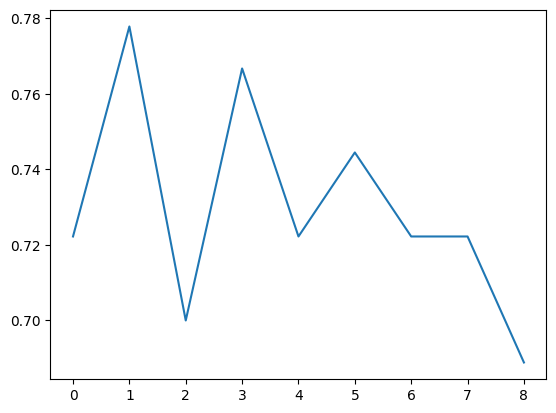

In [ ]:
pylab.plot([i[0]/10/len(val_cids) for i in beam_ans])

In [ ]:
beam_ans #new code

[[(4, 0)], [(6, 0)], [(7, 8)], [(7, 9)]]

In [ ]:
beam_ans #new code

[[5, 5, 8], [7, 8, 5], [6, 6, 4], [7, 5, 3]]

In [ ]:
with open("drive/MyDrive/table20240322.txt","w") as f:
  f.write(str(beam_ans))

In [ ]:
len(val_cids)*5

45

In [ ]:
np.array(beam_ans).shape

(4, 4, 2)

In [ ]:
top1 = np.array(beam_ans)[:,:,0]

In [ ]:
np.max(top1)

5

In [ ]:
top1

array([[38, 38, 39, 40],
       [35, 27, 32, 24],
       [30, 34, 30, 11],
       [31, 26, 18,  4]])

In [ ]:
top1

array([[33, 37, 40, 40],
       [32, 33, 33, 28],
       [34, 35, 27, 10],
       [35, 27, 13,  7]])

Text(50.722222222222214, 0.5, 'beam')

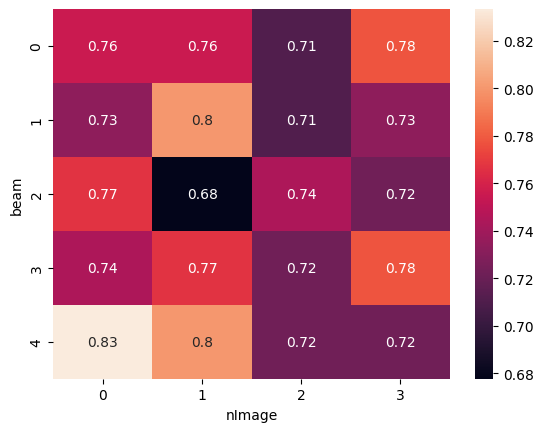

In [ ]:
import seaborn as sns
import pylab
# pylab.matshow(top1/(len(test_cids)*5))
# pylab.colorbar()
top1 = np.array(beam_ans)[:,:,0]
res = top1/(len(test_cids)*10)
sns.heatmap(res, annot=res)
pylab.xlabel("nImage")
pylab.ylabel("beam")

In [ ]:
np.array(beam_ans)[:,:,0]

array([[68, 68, 64, 70],
       [66, 72, 64, 66],
       [69, 61, 67, 65],
       [67, 69, 65, 70],
       [75, 72, 65, 65]])

In [ ]:
val_cids = test_cids = [8100, 7298, 40555, 13007, 61929, 93058, 220010, 97502, 93058]#14020

beam_ans = []
for r in np.arange(0,0.10,0.02):
  nImageAns = []
  for beam in range(1,5):
    top1_count = 0
    top3_count = 0
    for val_cid in val_cids:
      val_cid = [val_cid]
      for sample in range(10):
        val_names = list(["images/"+i for i in np.random.choice([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cid], 1, replace=False)])
        correct = molecules_rows[molecules_rows[" cid"]==val_cid[0]]["canonicalsmiles"].item()
        predicted = myeval(val_names, beam, "sum", r=r)
        top1_count = top1_count+1 if correct in predicted.split("\n")[:1] else top1_count
        if beam>=3:
          top3_count = top3_count+1 if correct in predicted.split("\n")[:3] else top3_count
    nImageAns.append((top1_count, top3_count))
  beam_ans.append(nImageAns)

In [ ]:
nImageAns = []
for beam in range(1,5):
  top1_count = 0
  top3_count = 0
  for val_cid in val_cids:
    val_cid = [val_cid]
    for sample in range(5):
      val_names = list(["images/"+i for i in np.random.choice([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cid], 1, replace=False)])
      correct = molecules_rows[molecules_rows[" cid"]==val_cid[0]]["canonicalsmiles"].item()
      predicted = myeval(val_names, beam, "sum", r=0.05)
      top1_count = top1_count+1 if correct in predicted.split("\n")[:1] else top1_count
      if beam>=3:
        top3_count = top3_count+1 if correct in predicted.split("\n")[:3] else top3_count
  nImageAns.append((top1_count, top3_count))

In [ ]:
nImages

4

In [ ]:
nImageAns

[(35, 0), (34, 0), (35, 43), (35, 43)]

In [ ]:
import os
len(["images/"+i for i in ([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cids])])

83

In [ ]:
35/len(val_cids)*5

19.444444444444443

[35, 38, 43, 39, 42]
[35, 38, 43, 39, 42]


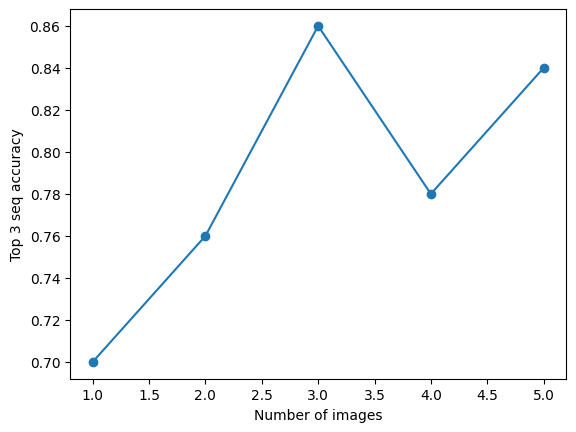

In [ ]:
import pylab
pylab.rcParams['text.usetex'] = False
pylab.plot(np.arange(1,6),np.array(beam_ans)/(len(val_cids)*5))
pylab.scatter(np.arange(1,6),np.array(beam_ans)/(len(val_cids)*5))
pylab.xlabel("Number of images")
pylab.ylabel("Top 3 seq accuracy")
print(beam_ans)
print(beam_ans)

<ipython-input-61-0294dfa42409>:8: RuntimeWarning: overflow encountered in exp
  t = np.exp(np.array(x)/t)
<ipython-input-61-0294dfa42409>:9: RuntimeWarning: invalid value encountered in divide
  return t/np.sum(t)


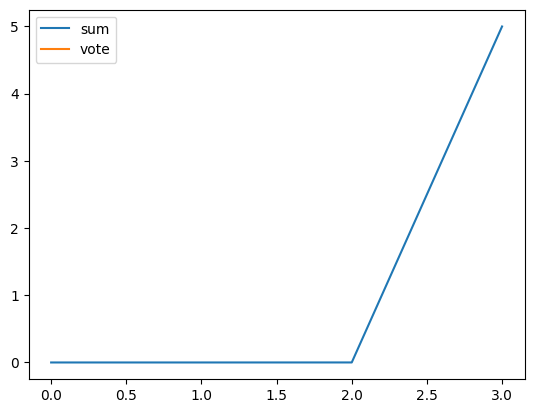

In [ ]:
out = [[0,1,2,10],
       [0,2,5,20],
       [0,2,5,20],
       [0,10,20,30],
       [0,10,20,30],
        ]
def softmax(x,t):
  t = np.exp(np.array(x)/t)
  return t/np.sum(t)
out1 = []
for i in out:
  out1.append(softmax(i,1))
out1 = np.sum(out1, axis=0)
out2 = []
for i in out:
  out2.append(softmax(i,0.1))


out2 = np.sum(out2, axis=0)
pylab.plot(out1, label="sum")
pylab.plot(out2, label="vote")
pylab.legend()

In [ ]:
val_cids = [8100, 7298, 40555, 13007, 61929, 93058, 220010, 14020, 97502, 93058]
val_names = [i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cids]

[4.53811699e-05 1.23382185e-04 4.26701090e-04 4.99940454e+00]
[3.72007598e-44 8.19401262e-40 1.80485140e-35 5.00000000e+00]
